In [181]:
!git clone https://github.com/kevinmbeaulieu/self-driving-car-track.git

fatal: destination path 'self-driving-car-track' already exists and is not an empty directory.


In [182]:
!ls self-driving-car-track/

driving_log.csv  IMG


In [183]:
!pip3 install imgaug

In [0]:
import cv2
from imgaug import augmenters as iaa
import keras
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ntpath
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [185]:
datadir = 'self-driving-car-track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_499.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_499.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_499.jpg,0.0,0.0,0,0.000078
1,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_620.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_620.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_620.jpg,0.0,0.0,0,0.000080
2,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_752.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_752.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_752.jpg,0.0,0.0,0,0.000081
3,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_867.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_867.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_867.jpg,0.0,0.0,0,0.000078
4,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/center_2020_01_13_19_22_12_999.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/left_2020_01_13_19_22_12_999.jpg,/Users/kevinmbeaulieu/Google-Drive/Code/Udemy/Complete Self-Driving Car Course/Behavioral Cloning/IMG/right_2020_01_13_19_22_12_999.jpg,0.0,0.0,0,0.000079


In [0]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

In [187]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_01_13_19_22_12_499.jpg,left_2020_01_13_19_22_12_499.jpg,right_2020_01_13_19_22_12_499.jpg,0.0,0.0,0,0.000078
1,center_2020_01_13_19_22_12_620.jpg,left_2020_01_13_19_22_12_620.jpg,right_2020_01_13_19_22_12_620.jpg,0.0,0.0,0,0.000080
2,center_2020_01_13_19_22_12_752.jpg,left_2020_01_13_19_22_12_752.jpg,right_2020_01_13_19_22_12_752.jpg,0.0,0.0,0,0.000081
3,center_2020_01_13_19_22_12_867.jpg,left_2020_01_13_19_22_12_867.jpg,right_2020_01_13_19_22_12_867.jpg,0.0,0.0,0,0.000078
4,center_2020_01_13_19_22_12_999.jpg,left_2020_01_13_19_22_12_999.jpg,right_2020_01_13_19_22_12_999.jpg,0.0,0.0,0,0.000079


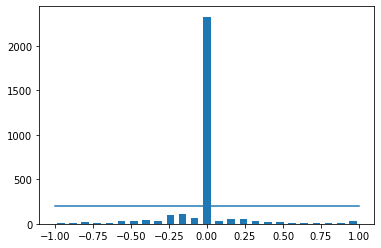

In [188]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 3060
removed: 2127
remaining: 933


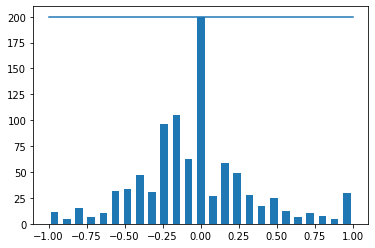

In [189]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, bins = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [0]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [192]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('training samples: {}\nValid samples: {}'.format(len(X_train), len(X_valid)))

training samples: 746
Valid samples: 187


Text(0.5, 1.0, 'validation set')

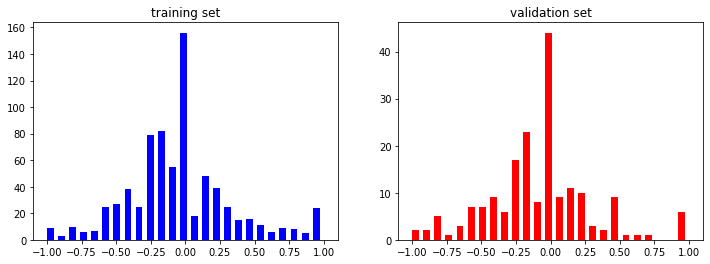

In [193]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('validation set')

In [0]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1, 'zoomed image')

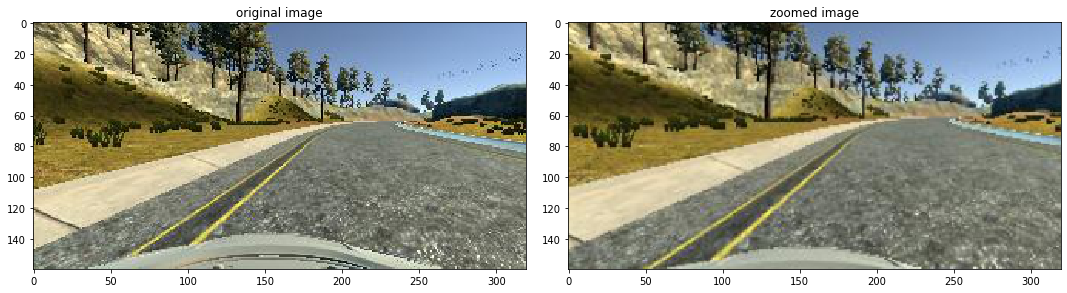

In [195]:
image = image_paths[random.randint(0, 933)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original image')
axes[1].imshow(zoomed_image)
axes[1].set_title('zoomed image')

In [0]:
def pan(image):
    pan = iaa.Affine(translate_percent={'x': [-0.1, 0.1], 'y': [-0.1, 0.1]})
    image = pan.augment_image(image)
    return image

Text(0.5, 1, 'panned image')

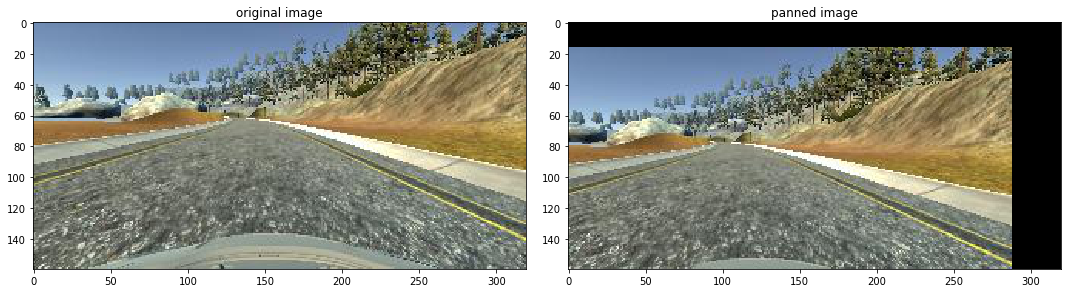

In [197]:
image = image_paths[random.randint(0, 933)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original image')
axes[1].imshow(panned_image)
axes[1].set_title('panned image')

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1, 'brightness altered image')

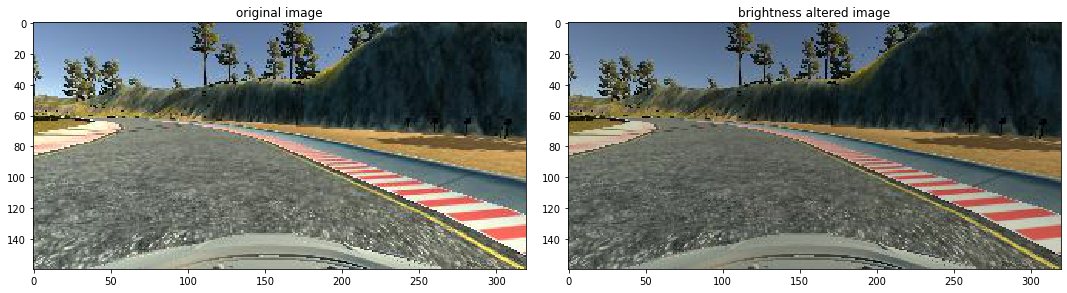

In [199]:
image = image_paths[random.randint(0, 933)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original image')
axes[1].imshow(brightness_altered_image)
axes[1].set_title('brightness altered image')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle *= - 1
    return image, steering_angle

Text(0.5, 1, 'flipped image - steering angle: 0.1097735')

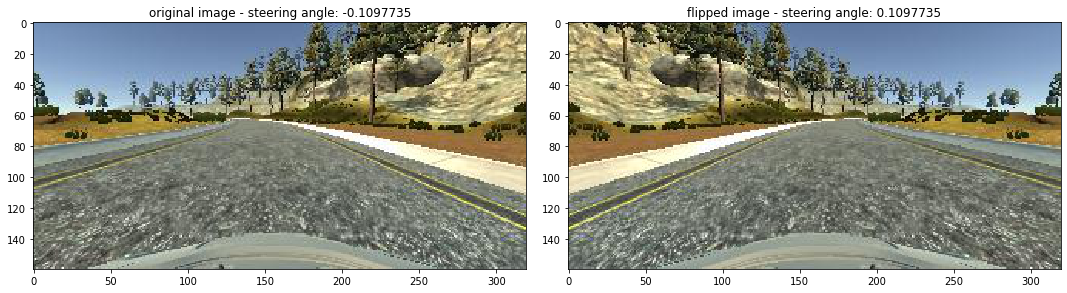

In [201]:
random_index = random.randint(0, 933)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original image - ' + 'steering angle: ' + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title('flipped image - ' + 'steering angle: ' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

In [203]:
fig, axes = plt.subplots(10, 2, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axes[i][0].imshow(original_image)
    axes[i][0].set_title('original image')
    axes[i][1].imshow(augmented_image)
    axes[i][1].set_title('augmented image')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
 def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1, 'preprocessed image')

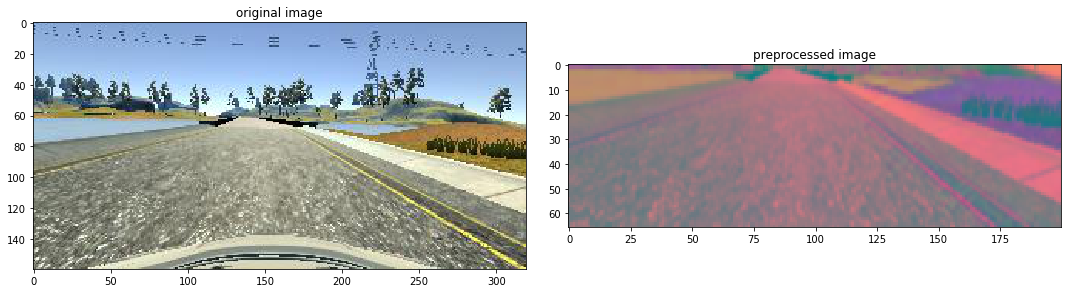

In [205]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('original image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('preprocessed image')

In [0]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if is_training:
                im, steering = random_augment(image_paths[random_index], steering_angles[random_index])
            else:
                im, steering = mpimg.imread(image_paths[random_index]), steering_angles[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield [np.asarray(batch_img), np.asarray(batch_steering)]

Text(0.5, 1, 'validation image')

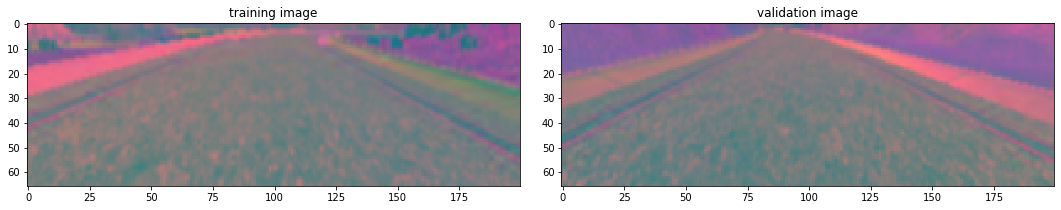

In [207]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(x_train_gen[0])
axes[0].set_title('training image')
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('validation image')

In [0]:
# X_train = np.array(list(map(img_preprocess, list(map(mpimg.imread, X_train)))))
# X_valid = np.array(list(map(img_preprocess, list(map(mpimg.imread, X_valid)))))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
# plt.axis('off')
# print(X_train.shape)

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model


In [211]:
model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [212]:
history = model.fit_generator(
    batch_generator(
        X_train,
        y_train,
        100,
        1
    ),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(
        X_valid,
        y_valid,
        100,
        0
    ),
    validation_steps=200,
    verbose=1,
    shuffle=1
)

Epoch 1/10
300/300 [==============================] - 349s 1s/step - loss: 0.1697 - val_loss: 0.1201
Epoch 2/10
300/300 [==============================] - 344s 1s/step - loss: 0.1303 - val_loss: 0.1067
Epoch 3/10
300/300 [==============================] - 341s 1s/step - loss: 0.1230 - val_loss: 0.1057
Epoch 4/10
300/300 [==============================] - 333s 1s/step - loss: 0.1190 - val_loss: 0.1122
Epoch 5/10
300/300 [==============================] - 339s 1s/step - loss: 0.1104 - val_loss: 0.0992
Epoch 6/10
300/300 [==============================] - 340s 1s/step - loss: 0.1094 - val_loss: 0.1147
Epoch 7/10
300/300 [==============================] - 343s 1s/step - loss: 0.1055 - val_loss: 0.1052
Epoch 8/10
300/300 [==============================] - 341s 1s/step - loss: 0.1017 - val_loss: 0.1127
Epoch 9/10
300/300 [==============================] - 341s 1s/step - loss: 0.1013 - val_loss: 0.1153
Epoch 10/10
300/300 [==============================] - 336s 1s/step - loss: 0.0995 - val_lo

Text(0.5, 0, 'epoch')

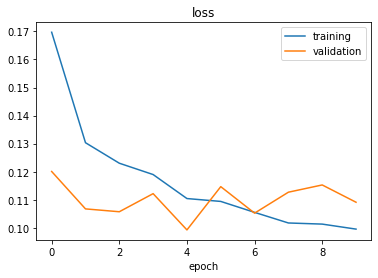

In [213]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files

files.download('model.h5')